In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import spacy
import pickle
import itertools
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/jason/Flatiron/MOD4/cleaned_reviews_dataframe')

In [3]:
df.head()

,reviews,sentiment,cleaned_reviews
0,Working with one of the best Shakespeare sourc...,0,work with one of the good shakespeare source t...
1,"Well...tremors I, the original started off in ...",0,well tremor i the original start off in and i ...
2,Ouch! This one was a bit painful to sit throug...,0,ouch this one be a bit painful to sit through ...
3,"I've seen some crappy movies in my life, but t...",0,-PRON- have see some crappy movie in -PRON- li...
4,"""Carriers"" follows the exploits of two guys an...",0,carrier follow the exploit of two guy and tw...


### StopWords

In [4]:
# create stopwords and update as spacy lemmatizer converts all pronouns (i, we, us, etc..) to -PRON-
stopwords_list = stopwords.words('english')+['pron', '-PRON-']
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

# Modeling

In [5]:
#function to train test split our cleaned reviews and vectorize using specific stopwords
def split_vectorize(predictor, target, vectorizer, stopwords):
    #TRAIN/TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(predictor, target, random_state=333)
    
    # vectorize our predictor column, n_gram range was chosen as we found having groups of words
    # increased our score, min_df of 7 got rid of many nonsensical tokens such as 'zzzhf' and kept
    # dataframe at a manageable size (around 50,000 columns)
    vect = vectorizer(ngram_range=(1, 3), min_df = 7, stop_words=stopwords)
    
    #fit/transform train set and transform tet set
    X_train=vect.fit_transform(X_train)
    X_test=vect.transform(X_test)
    
    # make into a dataframe with the ngrams as column names
    X_train = pd.DataFrame(X_train.toarray(), columns=vect.get_feature_names())
    X_test = pd.DataFrame(X_test.toarray(), columns=vect.get_feature_names())
    
    #return the 
    return X_train, X_test, y_train, y_test, vectorizer    

## Baseline

From our eda we have shown that our classes are completely balanced meaning we can either choose negative or positive for all reviews and we would be right half of the time for this dataset. That of course will not work well when we look at new data which could have a class imbalance. We aim to produce at model that will perform well on our training data and that will evaluate just as well on our holdout set.

## Bag Of Words

In [6]:
#train test split and vectorize our cleaned reviews using CountVectorizer
X_train, X_test, y_train, y_test, BOW_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], CountVectorizer, stopwords_list)

In [7]:
#pickle our BOW vectorizer for use with holdout set
pickle_out = open("BOW_vect.pickle","wb")
pickle.dump(BOW_vect, pickle_out)
pickle_out.close()

### Logistic Regression

In [8]:
#INSTANTIATE LOGISTIC REGRESSION
logreg = LogisticRegression(C = .009, random_state = 333)


#fit to training set
logreg.fit(X_train, y_train)

#predict on train and test set
y_pred_log_train = logreg.predict(X_train)
y_pred_log_test = logreg.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_log_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_log_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_log_train, y_train))
print('Test F1 score: ', f1_score(y_pred_log_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_log_test)/len(y_test))

Train Accuracy score:  0.92576
Test Accuracy score:  0.8816

Train F1 score:  0.9264969901784771
Test F1 score:  0.8835012594458439

Confusion matrix test set: 
 [[0.43264 0.06608]
 [0.05232 0.44896]]


In [42]:
# (spoiler) pickling our best model with BOW vectorization
pickle_out = open("log_reg_mod.pickle","wb")
pickle.dump(logreg, pickle_out)
pickle_out.close()

### Naive Bayes

In [43]:
#INSTANTIATE NB Classifier
Naive = MultinomialNB(alpha=.1, fit_prior= True)

#fit to training set
Naive.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive.predict(X_train)
y_pred_nb_test = Naive.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test)/len(y_test))

Train Accuracy score:  0.92544
Test Accuracy score:  0.87376

Train F1 score:  0.9254479522184301
Test F1 score:  0.8743030109925124

Confusion matrix test set: 
 [[0.43472 0.064  ]
 [0.06224 0.43904]]


### Decision Tree

In [11]:
# INSATNTIATE DECISION TREE MODEL
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train, y_train))
print('Test F1 score: ', f1_score(y_pred_tree_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test)/len(y_test))

Train Accuracy score:  1.0
Test Accuracy score:  0.73712

Train F1 score:  1.0
Test F1 score:  0.7358945507153191

Confusion matrix test set: 
 [[0.37088 0.12784]
 [0.13504 0.36624]]


### Random Forest

In [48]:
#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced')

#fit to training set
rfc.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train = rfc.predict(X_train)
y_pred_rfc_test = rfc.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train, y_train))
print('Test F1 score: ', f1_score(y_pred_rfc_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test)/len(y_test))

Train Accuracy score:  1.0
Test Accuracy score:  0.8584

Train F1 score:  1.0
Test F1 score:  0.8607833883907503

Confusion matrix test set: 
 [[0.42064 0.07808]
 [0.06352 0.43776]]


### Best BOW model with updated stopwords

In [27]:
# adding in most common words from Unigram analysis
stopwords_new = stopwords_list + ['movie', 'film']

In [28]:
#train test split and vectorize our cleaned reviews using CountVectorizer and updated stopwords
X_train, X_test, y_train, y_test, BOW_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], CountVectorizer, stopwords_new)

In [15]:
#INSTANTIATE LOGISTIC REGRESSION
logreg_stop = LogisticRegression(C = .01, random_state = 333)
# can choose a regularization C = ? to penalize so it doesnt overfit

#fit to training set
logreg_stop.fit(X_train, y_train)

#predict on train and test set
y_pred_log_train = logreg_stop.predict(X_train)
y_pred_log_test = logreg_stop.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_log_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_log_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_log_train, y_train))
print('Test F1 score: ', f1_score(y_pred_log_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_log_test)/len(y_test))

Train Accuracy score:  0.9269866666666666
Test Accuracy score:  0.88176

Train F1 score:  0.9276388815476505
Test F1 score:  0.8835303388494878

Confusion matrix test set: 
 [[0.43328 0.06544]
 [0.0528  0.44848]]


After including the most common words that show up in each type of review we see that it does not really have an effect on our scores. We would choose to leave them in as the inclusion of them can give us a better sense of the context of each feature.

### Feature Importance (best model)

In [9]:
#get coefficient values for features and create dict with feature and importance
dictionary_logreg = dict(zip(list(X_train.columns), list(logreg.coef_[0])))

#sort dictionary by most important features
dictionary_logreg = {k: v for k, v in sorted(dictionary_logreg.items(), key=lambda item: abs(item[1]))}

# make dictionary a list with most important features at top
importance = dictionary_logreg.items()
impt_features = list(importance)[::-1]

In [11]:
# Top ten most important features for logistic regression model
log_features = pd.DataFrame(impt_features[:10], columns = ['Feature', 'Importance'])

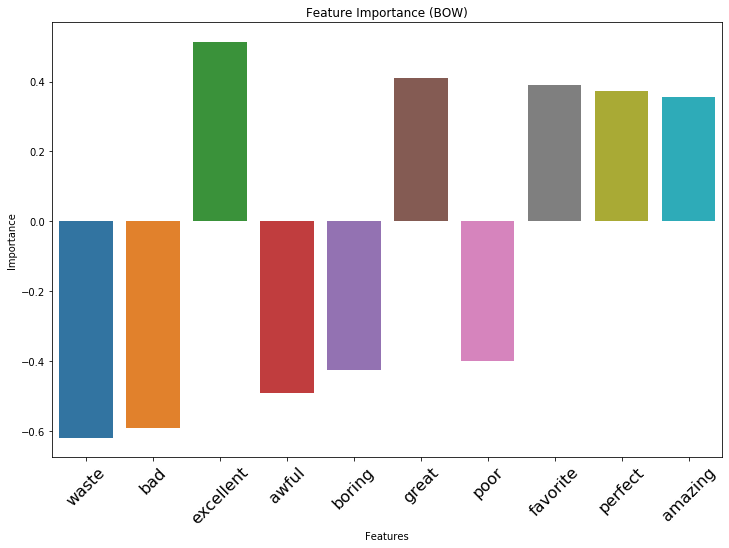

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(log_features['Feature'], log_features['Importance'])
plt.xticks(fontsize=16)
plt.xticks(rotation=45)
plt.title('Feature Importance (BOW)')
plt.xlabel('Features')
plt.ylabel('Importance')
sns.set_style()
plt.show()

From our most important features we can see that many of these key words are more descriptive and not general like "good", with the only exception being the word "bad". 

## TFIDF

In [20]:
#train test split and vecotrize our cleaned reviews using CountVectorizer
X_train, X_test, y_train, y_test, TFIDF_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], TfidfVectorizer, stopwords_list)

In [21]:
# Pickling TFIDF Vectorizer
pickle_out = open("TFIDF_vect.pickle","wb")
pickle.dump(TFIDF_vect, pickle_out)
pickle_out.close()

### Logistic Regression

In [22]:
#INSTANTIATE LOGISTIC REGRESSION
logreg = LogisticRegression(C = .01, random_state = 333)

#fit to training set
logreg.fit(X_train, y_train)

#predict on train and test set
y_pred_log_train = logreg.predict(X_train)
y_pred_log_test = logreg.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_log_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_log_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_log_train, y_train))
print('Test F1 score: ', f1_score(y_pred_log_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_log_test)/len(y_test))

Train Accuracy score:  0.8417066666666667
Test Accuracy score:  0.83392

Train F1 score:  0.8484012667279599
Test F1 score:  0.8414298808432631

Confusion matrix test set: 
 [[0.39328 0.10544]
 [0.06064 0.44064]]


### Naive Bayes

In [21]:
#INSTANTIATE NB Classifier
Naive = MultinomialNB(alpha=0.1, fit_prior= True)

#fit to training set
Naive.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive.predict(X_train)
y_pred_nb_test = Naive.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test)/len(y_test))

Train Accuracy score:  0.94192
Test Accuracy score:  0.87616

Train F1 score:  0.9423046357615894
Test F1 score:  0.8781486146095718

Confusion matrix test set: 
 [[0.42992 0.0688 ]
 [0.05504 0.44624]]


In [22]:
# pickling our best model implementing TFIDF
pickle_out = open("nb_mod.pickle","wb")
pickle.dump(Naive, pickle_out)
pickle_out.close()

### Decision Tree

In [23]:
# INSATNTIATE DECISION TREE MODEL
tree = DecisionTreeClassifier(class_weight = 'balanced',random_state = 333)

#fit to training set
tree.fit(X_train, y_train)

#predict on train and test set
y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_tree_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_tree_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_tree_train, y_train))
print('Test F1 score: ', f1_score(y_pred_tree_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_tree_test)/len(y_test))

Train Accuracy score:  1.0
Test Accuracy score:  0.71728

Train F1 score:  1.0
Test F1 score:  0.7174156404925636

Confusion matrix test set: 
 [[0.3584  0.14032]
 [0.1424  0.35888]]


### Random Forest

In [24]:
#INSTANTIATE RANDOM FOREST MODEL
rfc = RandomForestClassifier(random_state = 333, class_weight='balanced')

#fit to training set
rfc.fit(X_train, y_train)

#predict on train and test set
y_pred_rfc_train = rfc.predict(X_train)
y_pred_rfc_test = rfc.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_rfc_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_rfc_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_rfc_train, y_train))
print('Test F1 score: ', f1_score(y_pred_rfc_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_rfc_test)/len(y_test))

Train Accuracy score:  1.0
Test Accuracy score:  0.85312

Train F1 score:  1.0
Test F1 score:  0.8539147040101845

Confusion matrix test set: 
 [[0.42384 0.07488]
 [0.072   0.42928]]


## Best TFIDF Model with updated stopwords

In [25]:
#train test split and vectorize our cleaned reviews using updated stopwords
X_train, X_test, y_train, y_test, TFIDF_vect = split_vectorize(
    df['cleaned_reviews'], df['sentiment'], TfidfVectorizer, stopwords_new)

In [26]:
#INSTANTIATE NB Classifier
Naive_stop = MultinomialNB(alpha=0.1, fit_prior= True)

#fit to training set
Naive_stop.fit(X_train,y_train)

#predict on train and test set
y_pred_nb_train = Naive_stop.predict(X_train)
y_pred_nb_test = Naive_stop.predict(X_test)


# checking accuracy
print('Train Accuracy score: ', accuracy_score(y_pred_nb_train, y_train))
print('Test Accuracy score: ', accuracy_score(y_pred_nb_test, y_test))
print()
# checking F1
print('Train F1 score: ', f1_score(y_pred_nb_train, y_train))
print('Test F1 score: ', f1_score(y_pred_nb_test,y_test))
print()
# print confusion matrix
print('Confusion matrix test set: \n', confusion_matrix(y_test, y_pred_nb_test)/len(y_test))

Train Accuracy score:  0.94112
Test Accuracy score:  0.87696

Train F1 score:  0.941482031167179
Test F1 score:  0.8788785635533155

Confusion matrix test set: 
 [[0.43056 0.06816]
 [0.05488 0.4464 ]]


As with the BOW model, there was really no difference in our scores after removing the most common words from both types of review. We will decide to use the model with them in as there could be value in knowing the context of word groupings with those new stop words left in.

### Feature Importance (Best Model)

In [27]:
#get coefficient values for features and create dict with feature and importance
dictionary_nb = dict(zip(list(X_train.columns), list(Naive.coef_[0])))

#sort dictionary by most important features
dictionary_nb = {k: v for k, v in sorted(dictionary_nb.items(), key=lambda item: abs(item[1]))}

# make dictionary a list with most important features at top
importance = dictionary_nb.items()
nb_features = list(importance)[::-1]

In [30]:
NB_features = pd.DataFrame(nb_features[:10], columns = ['Feature', 'Importance'])

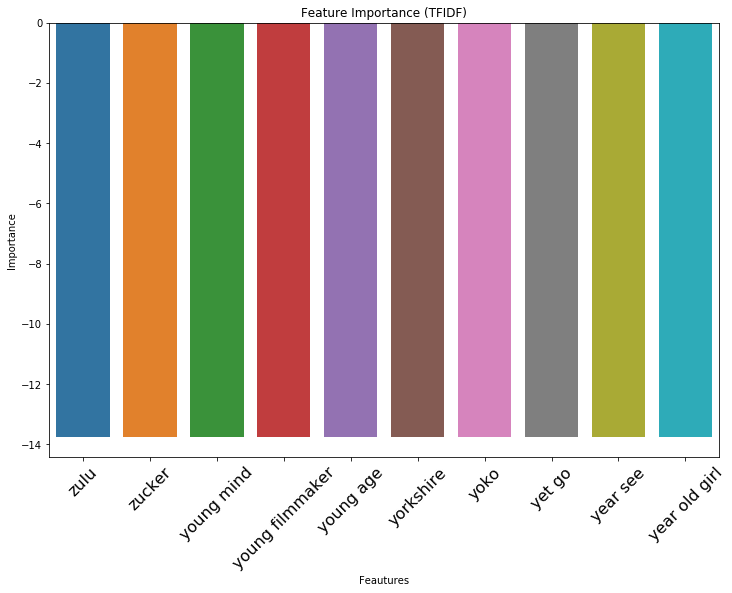

In [34]:
plt.figure(figsize=(12,8))
sns.barplot(NB_features['Feature'], NB_features['Importance'])
plt.xticks(fontsize=16)
plt.xticks(rotation=45)
plt.title('Feature Importance (TFIDF)')
plt.xlabel('Features')
plt.ylabel('Importance')
sns.set_style()
plt.show()

Unlike the BOW model we see more groupings of words show up in the TFIDF's top features. Some of these words seem rather odd though in comparison to the BOW model. For instance take the word  "zulu", perhaps that is from a movie that is generally very negative and if it shows up anywhere else the review is automatically classified as negative